In [13]:
%cd drive/MyDrive/Semantic Image Segmentation

[Errno 2] No such file or directory: 'drive/MyDrive/Semantic Image Segmentation'
/content/drive/MyDrive/Semantic Image Segmentation


In [14]:
import os
import time
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
from tqdm.notebook import tqdm

from utils.dataloader import ImagePreprocessing, make_anno_palette_dict, make_datapath_list
from utils.psp import PSPLoss, PSPNet

In [15]:
# 初期設定
n_classes = 8

BATCH_SIZE = 5
FLAG_INITALIZATION = False
NUM_EPOCHS = 50
PRETRAINED_PARAMS = "./weights/pspnet50_35epoch.pth"
TARGET_DIR = "./data/USR-248/"
VAL_INTERVAL = 5

# Setup seeds
SEED = 19970628
torch.manual_seed(SEED)
np.random.seed(SEED)

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda:0


In [17]:
## dataloader

palette_dict, anno_dict = \
  make_anno_palette_dict(root=TARGET_DIR, filename='label_colors.txt')

dir_list = ['images', 'masks']
train_img_list, train_anno_list, val_img_list, val_anno_list = \
  make_datapath_list(root=TARGET_DIR, dir=dir_list)

print('num_data: ', len(train_img_list) + len(val_img_list))
print(palette_dict)
print(anno_dict)

num_data:  1249
{(0, 0, 0): 0, (0, 0, 255): 1, (0, 255, 0): 2, (0, 255, 255): 3, (255, 0, 0): 4, (255, 0, 255): 5, (255, 255, 0): 6, (255, 255, 255): 7}
{0: 'Background waterbody', 1: 'Human divers', 2: 'Plants/sea-grass', 3: 'Wrecks/ruins', 4: 'Robots/instruments', 5: 'Reefs and invertebrates', 6: 'Fish and vertebrates', 7: 'Sand/sea-floor (& rocks)'}


In [29]:
print(len(train_img_list))

1004


<PIL.BmpImagePlugin.BmpImageFile image mode=RGB size=640x480 at 0x7FC7505EEEB8>


(-0.5, 639.5, 479.5, -0.5)

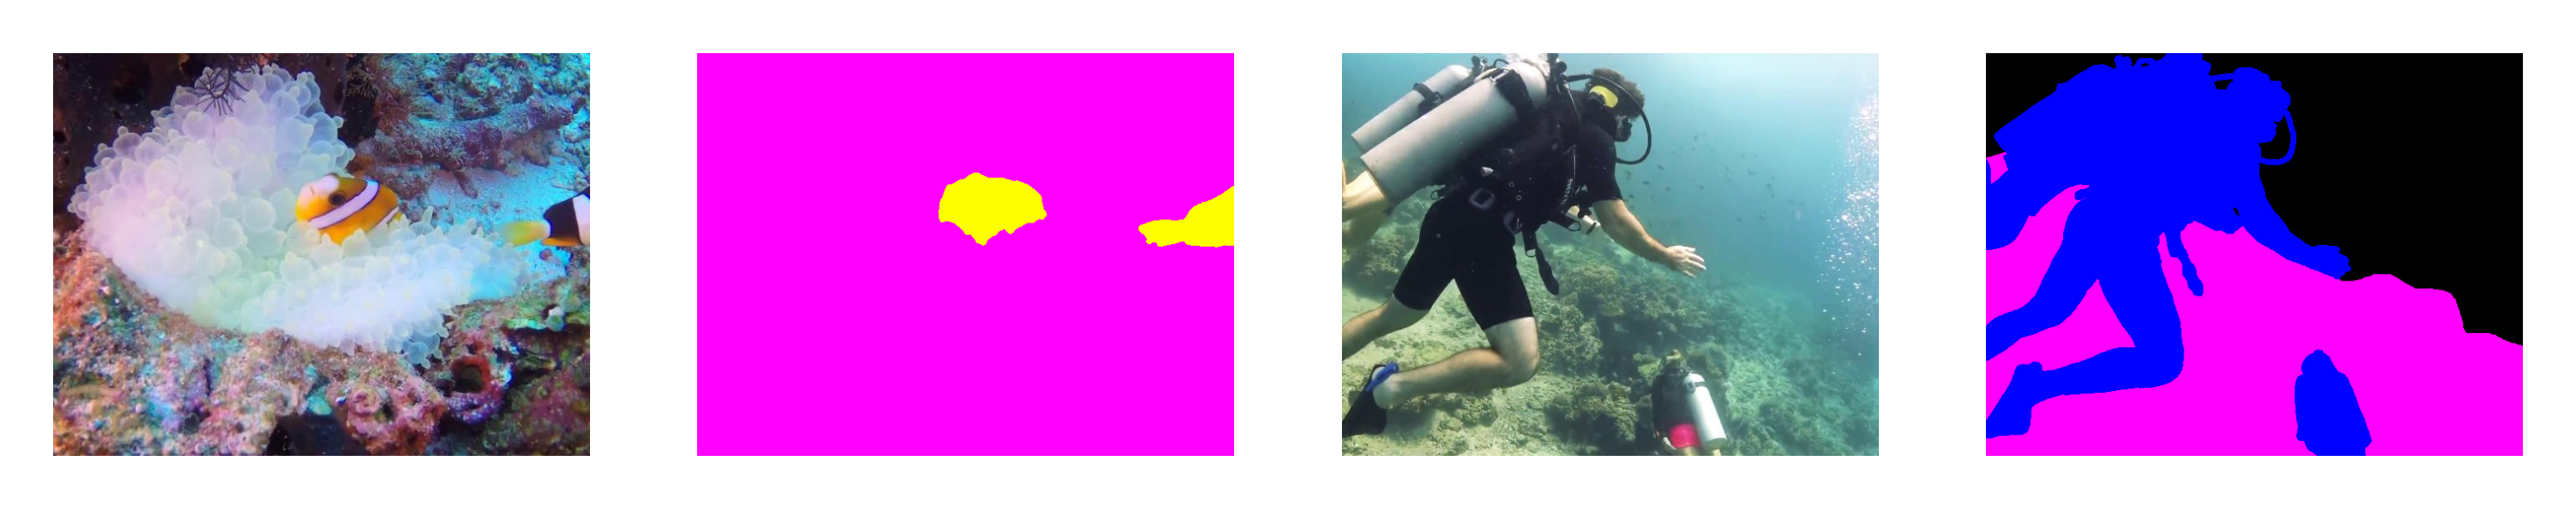

In [18]:
# 動作確認
import matplotlib.pyplot as plt

fig = plt.figure(dpi=640)
ax1 = fig.add_subplot(141)
t = Image.open(train_img_list[0])
ax1.imshow(t)
ax1.axis('off')

ax2 = fig.add_subplot(142)
t = Image.open(train_anno_list[0])
print(t)
ax2.imshow(t)
ax2.axis('off')

ax3 = fig.add_subplot(143)
t = Image.open(val_img_list[0])
ax3.imshow(t)
ax3.axis('off')

ax4 = fig.add_subplot(144)
t = Image.open(val_anno_list[0])
ax4.imshow(t)
ax4.axis('off')

In [19]:
## network 
if os.path.exists(PRETRAINED_PARAMS):
  if FLAG_INITALIZATION:
    net = PSPNet(n_classes=150)
  else:
    net = PSPNet(n_classes=n_classes)
  state_dict = torch.load(PRETRAINED_PARAMS, map_location=torch.device(device))
  net.load_state_dict(state_dict)

if FLAG_INITALIZATION:
  # 分類用の畳み込み層を、出力数n_classes(=8)のものにつけかえる
  net.decode_feature.classification = nn.Conv2d(
    in_channels=512,
    out_channels=n_classes,
    kernel_size=1,
    stride=1,
    padding=0)

  net.aux.classification = nn.Conv2d(
    in_channels=256,
    out_channels=n_classes,
    kernel_size=1,
    stride=1,
    padding=0)
  
  # 付け替えた畳み込み層を初期化する。活性化関数がシグモイド関数なのでXavierを使用する。
  net.decode_feature.classification.apply(weights_init)
  net.aux.classification.apply(weights_init)

# ネットワークをGPUへ
net.to(device)

# ネットワークがある程度固定であれば、高速化させる
torch.backends.cudnn.benchmark = True

print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


In [20]:
## criterion
criterion = PSPLoss(aux_weight=0.4)

## optimizer
# ファインチューニングなので、学習率は小さく
optimizer = optim.SGD([
    {'params': net.feature_conv.parameters(), 'lr': 1e-3},
    {'params': net.feature_res_1.parameters(), 'lr': 1e-3},
    {'params': net.feature_res_2.parameters(), 'lr': 1e-3},
    {'params': net.feature_dilated_res_1.parameters(), 'lr': 1e-3},
    {'params': net.feature_dilated_res_2.parameters(), 'lr': 1e-3},
    {'params': net.pyramid_pooling.parameters(), 'lr': 1e-3},
    {'params': net.decode_feature.parameters(), 'lr': 1e-2},
    {'params': net.aux.parameters(), 'lr': 1e-2}],
  momentum=0.9, weight_decay=0.0001)

# スケジューラーの設定
import math
lambda_epoch = lambda epoch: math.pow((1- epoch/30), 0.9)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)

In [21]:
@dataclass
class USRDataset(data.Dataset):
  """PyTorchのDatasetクラスを継承。"""
  img_list: list # 画像のパスを格納したリスト
  anno_list: list # アノテーションへのパスを格納したリスト
  phase: str # 'train' or 'val' 学習か検証かを設定する。
  transform: object # 前処理クラスのインスタンス
  
  def __len__(self):
    return len(self.img_list)

  def __getitem__(self, index:int)->(torch.Tensor, int):

    # 1. 画像読み込み
    image_file_path = self.img_list[index]
    img = Image.open(image_file_path)   # [高さ][幅][色RGB]

    # 2. アノテーション画像読み込み
    anno_file_path = self.anno_list[index]
    anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]

    # 3. 前処理を実施
    img, anno_class_img = self.transform(self.phase, img, anno_class_img)

    return img, anno_class_img

In [22]:
def train_model(net:nn.Module, dataloader:data.dataloader, criterion:nn.Module, optimizer):
    # 画像の枚数
    num_imgs = len(dataloader.dataset)
    
    # イテレーションカウンタをセット
    iteration = 1

    # multiple minibatch
    batch_size = dataloader.batch_size
    batch_multiplier = 3

    # 開始時刻を保存
    t_epoch_start = time.time()
    t_iter_start = time.time()
    epoch_loss = 0.0  # epochの損失和

    net.train()  # モデルを訓練モードに
    optimizer.zero_grad()

    # データローダーからminibatchずつ取り出すループ
    count = 0  # multiple minibatch
    for imges, anno_class_imges in tqdm(dataloader):      
      # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
      if imges.size()[0] == 1:
        continue

      # GPUが使えるならGPUにデータを送る
      imges = imges.to(device)
      anno_class_imges = anno_class_imges.to(device)

      # multiple minibatchでのパラメータの更新
      if count == 0:
        optimizer.step()
        optimizer.zero_grad()
        count = batch_multiplier

      # 順伝搬（forward）計算
      outputs = net(imges)
      loss = criterion(outputs, anno_class_imges.long()) / batch_multiplier
      loss.backward()  # 勾配の計算
      count -= 1  # multiple minibatch

      if (iteration % 10 == 0):  # 10iterに1度、lossを表示
        t_iter_finish = time.time()
        duration = t_iter_finish - t_iter_start
        show_loss = loss.item()/batch_size*batch_multiplier
        print(f'イテレーション {iteration} || Loss: {show_loss:.4f} || 10iter: {duration:.4f} sec.')
        t_iter_start = time.time()

        epoch_loss += loss.item() * batch_multiplier
        iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print(f'Epoch_TRAIN_Loss:{epoch_loss/num_imgs:.4f}')
        print(f'timer:  {t_epoch_finish - t_epoch_start:.4f} sec.')
        t_epoch_start = time.time()

def validate_model(net, dataloader, criterion):
    # 画像の枚数
    num_imgs = len(dataloader.dataset) #20

    # multiple minibatch
    batch_multiplier = 3

    # 開始時刻を保存
    t_epoch_start = time.time()
    epoch_loss = 0.0  # epochの損失和

    net.eval()   # モデルを検証モードに
    
    # データローダーからminibatchずつ取り出すループ
    for imges, anno_class_imges in tqdm(dataloader):
      # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
      if imges.size()[0] == 1:
        continue

      # GPUが使えるならGPUにデータを送る
      imges = imges.to(device)
      anno_class_imges = anno_class_imges.to(device)
      
      # 順伝搬（forward）計算
      with torch.no_grad():
        outputs = net(imges)
        loss = criterion(outputs, anno_class_imges.long()) / batch_multiplier

      epoch_loss += loss.item() * batch_multiplier

      # epochのphaseごとのlossと正解率
      t_epoch_finish = time.time()
      print('-------------')
      print(f'Epoch_VAL_Loss:{epoch_loss/num_imgs:.4f}')
      print(f'timer:  {t_epoch_finish - t_epoch_start:.4f} sec.')
      t_epoch_start = time.time()

def weights_init(m):
  if isinstance(m, nn.Conv2d):
    nn.init.xavier_normal_(m.weight.data)
    if m.bias is not None:  # バイアス項がある場合
      nn.init.constant_(m.bias, 0.0)

In [23]:
train_dataset = USRDataset(
  train_img_list,
  train_anno_list,
  phase="train",
  transform=ImagePreprocessing(
    input_size=475,
    palette_dict=palette_dict)
  )
train_dataloader = data.DataLoader(
  train_dataset,
  batch_size=BATCH_SIZE,
  shuffle=True)

val_dataset = USRDataset(
  val_img_list,
  val_anno_list,
  phase="val",
  transform=ImagePreprocessing(
    input_size=475,
    palette_dict=palette_dict)
  )
val_dataloader = data.DataLoader(
  val_dataset,
  batch_size=BATCH_SIZE,
  shuffle=False)

In [ ]:
# execute train/val/save
#validate_model(net, val_dataloader, criterion)
    
for epoch in range(31, NUM_EPOCHS+1):
  print('-------------')
  print(f'Epoch {epoch}/{NUM_EPOCHS}', end="")
  train_model(net, train_dataloader, criterion, optimizer)
  scheduler.step()  # 最適化schedulerの更新
  if epoch % VAL_INTERVAL == 0:
    #validate_model(net, val_dataloader, criterion)
    # 最後のネットワークを保存する
    torch.save(net.state_dict(), f'weights/pspnet50_{epoch}epoch.pth')

-------------
Epoch 31/50


-------------
Epoch 32/50


-------------
Epoch 33/50


-------------
Epoch 34/50


-------------
Epoch 35/50


-------------
Epoch 36/50

KeyboardInterrupt: ignored

# 推論

In [24]:
def infer(transform, palette, image_file_path, anno_file_path)->(Image, torch.Tensor, np.ndarray, Image, list):
  # 前処理
  img = Image.open(image_file_path)   # [高さ][幅][色RGB]
  anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
  xformed_img, xformed_anno_class = transform('val', img, anno_class_img) # torch.Size([3, 475, 475])

  # 実行
  x = xformed_img.to(device).unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 475, 475])
  outputs = net(x)

  # PSPNetの出力から最大クラスを求め、カラーパレット形式にし、画像サイズを元に戻す
  out = outputs[0][0]  # AuxLoss側は無視 yのサイズはtorch.Size([1, 32, 475, 475])
  out = out.detach().to('cpu').numpy()  # y：torch.Size([1, 32, 475, 475])
  out = np.argmax(out, axis=0)

  img_width, img_height = img.size
  anno_class_img = Image.fromarray(np.uint8(out), mode="P").resize((img_width, img_height), Image.NEAREST)
  anno_class_img.putpalette(p_palette)

  # 画像を透過させて重ねる
  trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
  anno_class_img = anno_class_img.convert('RGBA')  # カラーパレット形式をRGBAに変換
  
  palette = list()
  for x in range(img_width):
    for y in range(img_height):
      # 推論結果画像のピクセルデータを取得
      pixel = anno_class_img.getpixel((x, y))
      r, g, b, a = pixel
      if not (r, g, b) in palette:
        palette.append((r, g, b))
      
      # (0, 0, 0)の背景ならそのままにして透過させる
      if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
        continue
      else:
        # それ以外の色は用意した画像にピクセルを書き込む
        trans_img.putpixel((x, y), (r, g, b, 150))
   
  result = Image.alpha_composite(img.convert('RGBA'), trans_img)

  return img, xformed_anno_class, out, result, palette


In [27]:
# 1. 前処理クラスの作成
IMAGE_PATH = './data/P6110004.JPG'

anno_file_path = val_anno_list[0] # 適当なアノテーション画像を用意

p_palette = list(np.array([key for key in palette_dict.keys()]).flatten()) # カラーパレットの情報を抜き出す

transform = ImagePreprocessing(
  input_size=475,
  palette_dict=palette_dict)
  
net.eval()

# 2. 推論
img, _, out, result, palette = infer(transform, p_palette, IMAGE_PATH, anno_file_path)

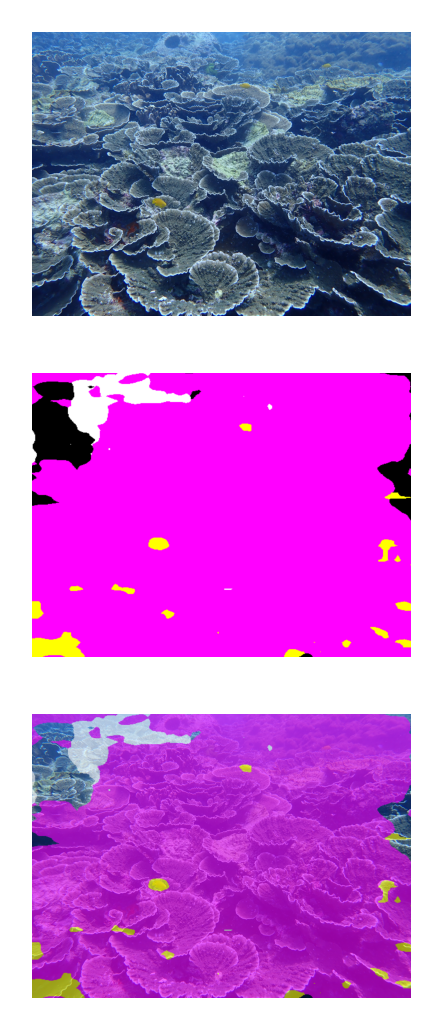

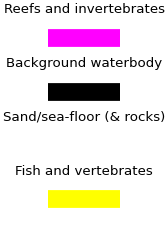

In [28]:
# 3. 描写
fig = plt.figure(dpi=320)
orig = fig.add_subplot(311)
orig.imshow(img)
orig.axis('off')

anno = Image.fromarray(np.uint8(out), mode="P").resize(img.size, Image.NEAREST)
anno.putpalette(p_palette)
paletted = fig.add_subplot(312)
paletted.imshow(anno)
paletted.axis('off')

overlapped = fig.add_subplot(313)
overlapped.imshow(result)
overlapped.axis('off')

plt.show()

# 4. カラーパレット表示
fig = plt.figure(dpi=32)

# カラーパレットを16進数表現に変換
rgb2hex = lambda r,g,b: '#%02X%02X%02X' % (r, g , b)
colors =  [rgb2hex(col[0],col[1],col[2]) for col in palette]

# カラーパレットを各色毎に描画
for idx, color in enumerate(colors):
  ax = fig.add_subplot(7, 1, idx+1)
  ax.set_xlim(0, 20)
  ax.hlines(0, 0, 20, colors=color, linewidth=40)
  ax.axis('off')

  color_name = anno_dict[palette_dict[tuple(palette[idx])]]
  
  ax.set_title(color_name, fontsize=30)

fig.subplots_adjust(right=0.5, top=3, wspace=0.1)
plt.show()

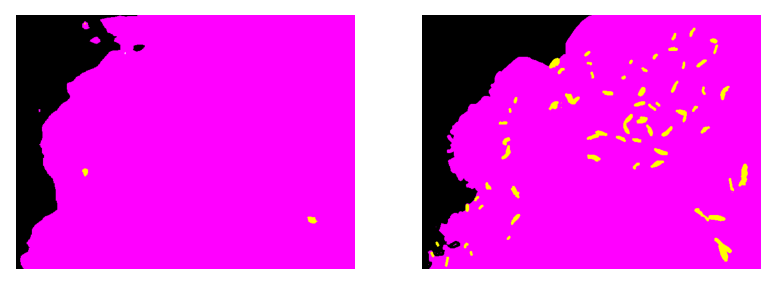

In [ ]:
fig = plt.figure(dpi=160)
generated = fig.add_subplot(121)
generated.imshow(anno)
generated.axis('off')

origin_img = Image.open(IMAGE_PATH[:-3] + 'bmp')

origin = fig.add_subplot(122)
origin.imshow(origin_img)
origin.axis('off')

plt.show()

# テスト(pixcel Accuracy)

In [ ]:
import glob

In [ ]:
"""
testフォルダの中身はtrain_valと重複している。
そのため, 重複するファイルを削除している。
"""

train_val_filename_list = [name[22:] for name in np.concatenate([train_img_list, val_img_list])]

testA_img_list, _, testB_img_list, _ = \
  make_datapath_list(root=TARGET_DIR+'test', dir=dir_list)
test_filename_list = [name[27:] for name in np.concatenate([testA_img_list, testB_img_list])]
test_filename_list = list(set(test_filename_list) - set(train_val_filename_list)) # 重複を削除
test_img_list = [os.path.join(TARGET_DIR, 'test', dir_list[0], path) for path in test_filename_list[:20]]
test_anno_list = [path.replace(dir_list[0], dir_list[1]).replace('jpg', 'bmp') for path in test_img_list]

print(len(test_img_list))

20


In [ ]:
sum_idx, sum_cnt = (0, 0)
for image_file_path, anno_file_path in zip(test_img_list, test_anno_list):
  print(image_file_path, end='\t')
  _, anno_class_img, out, _, _ = infer(transform, p_palette, image_file_path, anno_file_path)

  if anno_class_img is None:
    print('Skiped. (due to using a color not on the palette)')
    continue
  else:
    cnt = 0
    for h in range(475):
      for w in range(475):
        if out[h][w] == anno_class_img[h][w]:
          cnt += 1

    print(f'Accuracy: {100 * cnt/(475**2):.2f}%')
    sum_idx += 1
    sum_cnt += cnt
print(f'mean Accuracy: {100 * sum_cnt/(sum_idx * 475**2):.2f}%')

./data/USR-248/test/images/f_r_1216_.jpg	Accuracy: 72.87%
./data/USR-248/test/images/f_r_68_.jpg	Accuracy: 87.36%
./data/USR-248/test/images/w_r_209_.jpg	Accuracy: 92.00%
./data/USR-248/test/images/f_r_1518_.jpg	Accuracy: 95.62%
./data/USR-248/test/images/f_r_1296_.jpg	Accuracy: 98.07%
./data/USR-248/test/images/f_r_1887_.jpg	Accuracy: 81.80%
./data/USR-248/test/images/f_r_71_.jpg	Accuracy: 78.61%
./data/USR-248/test/images/f_r_814_.jpg	Accuracy: 52.11%
./data/USR-248/test/images/n_l_76_.jpg	Accuracy: 89.21%
./data/USR-248/test/images/f_r_2039_.jpg	Accuracy: 96.44%
./data/USR-248/test/images/w_r_19_.jpg	Accuracy: 28.31%
./data/USR-248/test/images/d_r_253_.jpg	Accuracy: 96.31%
./data/USR-248/test/images/w_r_68_.jpg	Accuracy: 86.11%
./data/USR-248/test/images/w_r_5_.jpg	Accuracy: 97.49%
./data/USR-248/test/images/w_r_70_.jpg	Accuracy: 64.97%
./data/USR-248/test/images/n_l_34_.jpg	Accuracy: 94.80%
./data/USR-248/test/images/f_r_673_.jpg	Accuracy: 73.88%
./data/USR-248/test/images/f_r_2001

In [ ]:
print(Image.open('./data/USR-248/test/images/n_l_49_.jpg'))
tmp2_anno = Image.open('./data/USR-248/test/masks/n_l_49_.bmp')
tmp2_anno.resize((475, 475), Image.NEAREST)
print(tmp2_anno)
tmp_img = Image.open('./data/USR-248/test/images/w_r_27_.jpg')
tmp_anno = Image.open('./data/USR-248/test/masks/w_r_27_.bmp')
tmp_anno.resize((475, 475), Image.NEAREST)
print(tmp_img)
print(tmp_anno)

#xformed_img, xformed_anno_class = transform('val', tmp_img, tmp_anno)

tmp_anno = np.array(tmp_anno)
print(np.array(tmp2_anno).shape)
print(tmp_anno.shape)

height, width, _ = tmp_anno.shape
anno_class_pallet = np.empty((height, width), dtype='uint8')
for h in range(height):
  for w in range(width):
    rgb_code = tuple(tmp_anno[h][w])

print(rgb_code)
#print(torch.from_numpy(anno_class_pallet)) # アノテーション画像をTensorに
print(palette_dict)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=960x540 at 0x7FFB12791908>
<PIL.BmpImagePlugin.BmpImageFile image mode=RGB size=960x540 at 0x7FFB12791908>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=590x375 at 0x7FFB12791358>
<PIL.BmpImagePlugin.BmpImageFile image mode=RGB size=590x430 at 0x7FFB127915C0>
(540, 960, 3)
(430, 590, 3)
(0, 255, 255)
{(0, 0, 0): 0, (0, 0, 255): 1, (0, 255, 0): 2, (0, 255, 255): 3, (255, 0, 0): 4, (255, 0, 255): 5, (255, 255, 0): 6, (255, 255, 255): 7}


In [ ]:
# 1. 前処理クラスの作成
transform = ImagePreprocessing(
  input_size=475,
  palette_dict=palette_dict)

# 2. 前処理
img = Image.open(image_file_path)   # [高さ][幅][色RGB]
img_width, img_height = img.size

# 適当なアノテーション画像を用意し、さらにカラーパレットの情報を抜き出す
anno_file_path = val_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
  
img, anno_class_img = transform('val', img, anno_class_img) # torch.Size([3, 475, 475])

# 3. 推論
net.eval()
  
x = img.to(device).unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 475, 475])
outputs = net(x)

# 4. PSPNetの出力から最大クラスを求め、カラーパレット形式にし、画像サイズを元に戻す
out = outputs[0][0]  # AuxLoss側は無視 yのサイズはtorch.Size([1, 32, 475, 475])
out = out.detach().to('cpu').numpy()  # y：torch.Size([1, 32, 475, 475])
out = np.argmax(out, axis=0)

p_palette = list(np.array([key for key in palette_dict.keys()]).flatten())
anno_class_img = Image.fromarray(np.uint8(out), mode="P").resize((img_width, img_height), Image.NEAREST)
anno_class_img.putpalette(p_palette)

# 5. 画像を透過させて重ねる
trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
anno_class_img = anno_class_img.convert('RGBA')  # カラーパレット形式をRGBAに変換
  
palette = list()
for x in range(img_width):
  for y in range(img_height):
    # 推論結果画像のピクセルデータを取得
    pixel = anno_class_img.getpixel((x, y))
    r, g, b, a = pixel
    if not (r, g, b) in palette:
      palette.append((r, g, b))
      
    # (0, 0, 0)の背景ならそのままにして透過させる
    if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
      continue
    else:
      # それ以外の色は用意した画像にピクセルを書き込む
      trans_img.putpixel((x, y), (r, g, b, 150))
   
img = Image.open(image_file_path)   # [高さ][幅][色RGB]
result = Image.alpha_composite(img.convert('RGBA'), trans_img)
